In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


### Create dataset

In [2]:
samples = 1500
X, Y = make_circles(samples, noise = 0.04)

In [3]:
X.shape, Y.shape

((1500, 2), (1500,))

In [4]:
# convert to pandas dataframe
df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'Label': Y})

In [5]:
df.head()

,X1,X2,Label
0,-0.767788,-0.182423,1
1,-0.403265,-0.692868,1
2,0.097396,1.020421,0
3,-0.083471,-0.827058,1
4,0.450071,0.575681,1


In [6]:
# check the distribution of labels
df.Label.value_counts()

Label
1    750
0    750
Name: count, dtype: int64

Nicely balanced dataset, no rare labels.

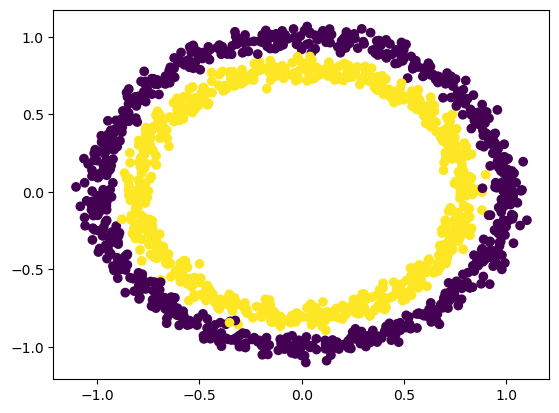

In [7]:
plt.scatter(x = df['X1'], y = df['X2'], c = df["Label"])

In [8]:
type(X)

numpy.ndarray

In [9]:
# convert to torch tensors
X = torch.from_numpy(X).type(torch.FloatTensor)
Y = torch.from_numpy(Y).type(torch.FloatTensor)

In [10]:
type(X), type(Y)

(torch.Tensor, torch.Tensor)

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,
                                                    test_size=.20,
                                                    random_state=42)

In [12]:
train_X[:5], train_Y[:5]

(tensor([[ 0.8297,  0.2428],
         [ 0.8106,  0.2320],
         [ 0.9819, -0.2293],
         [-0.2729, -0.9158],
         [-0.6849,  0.3895]]),
 tensor([1., 1., 0., 0., 1.]))

### Build the model

In [13]:
class CircularLinNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features= 6)
        self.layer_2 = nn.Linear(in_features=6, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))
    
# create instance and load on device
model_C = CircularLinNN().to(device)
model_C.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3587,  0.5990],
                      [-0.0968, -0.0168],
                      [-0.4740,  0.5914],
                      [ 0.5201,  0.5578],
                      [-0.0612, -0.4970],
                      [-0.6495,  0.3161]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.6946,  0.3718,  0.5341, -0.5979,  0.5573,  0.2950], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.3545, -0.3414,  0.2148, -0.3396,  0.1153,  0.0629]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([0.1707], device='cuda:0'))])

In [14]:
# alternative way of instatiating model
model_seq = nn.Sequential(
    nn.Linear(in_features=2,out_features=6),
    nn.Linear(in_features=6, out_features=1)
).to(device)

In [15]:
model_seq.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1307, -0.3845],
                      [ 0.6248,  0.6088],
                      [-0.5352,  0.6055],
                      [-0.5880,  0.5828],
                      [-0.2819,  0.6698],
                      [ 0.6927,  0.0622]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1489, -0.4261,  0.4393,  0.3801,  0.4804,  0.2805], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0924,  0.2417, -0.3838,  0.0623, -0.1190,  0.1840]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.0796], device='cuda:0'))])

So we get similar outcomes but the first approach is a lot more customizable

### Make preds with untrained model

In [16]:
with torch.inference_mode():
    pred_Y = model_C(test_X.to(device))     # never forget to send to the device

In [17]:
len(pred_Y), len(test_Y)

(300, 300)

In [18]:
pred_Y[:5], test_Y[:5]

(tensor([[0.9647],
         [0.7079],
         [1.1203],
         [0.9015],
         [1.1160]], device='cuda:0'),
 tensor([0., 0., 0., 1., 0.]))

Completely wrong outcomes!!

### Training the model

In [19]:
loss_func = nn.BCEWithLogitsLoss()    # BCE + Sigmoid
opti = torch.optim.SGD(params= model_C.parameters(), lr=.01)

# evaluation metrics

def accuracy_func(y_label, y_pred):
    # how many of the preds are correct
    # .item() → convert tensor scalar to Python number
    return (torch.eq(y_label, y_pred).sum().item()  / len(y_pred)) * 100

In [20]:
model_C.eval()
with torch.inference_mode():
    # raw logit -> out from linear transformation
    y = model_C(test_X.to(device))
    # convert to probs
    y = torch.round(torch.sigmoid(y)).squeeze()
len(y)

300

In [21]:
len(test_Y)

300

In [22]:
epochs = 200

# Put data to target device
# must do this step !!
train_X, train_Y = train_X.to(device), train_Y.to(device)
test_X, test_Y = test_X.to(device), test_Y.to(device)


for epoch in range(epochs):

    model_C.train()
    # 1. forward
    train_logit = model_C(train_X).squeeze()
    train_pred_Y = torch.round(torch.sigmoid(train_logit))

    # 2. calculate loss and accuracy
    train_loss = loss_func(train_logit, train_Y)
    accuracy = accuracy_func(train_Y, pred_Y)

    # 3. set optimizer grad to 0
    opti.zero_grad()

    # 4. backprop
    train_loss.backward()

    # 5. optimizer step
    opti.step()

    model_C.eval()
    with torch.inference_mode():
        test_logit = model_C(test_X).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logit))

        test_loss = loss_func(test_logit, test_Y)
        test_accuracy = accuracy_func(test_Y, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")

        
    

Epoch: 0 | Loss: 0.75723, Accuracy: 0.00% | Test loss: 0.77159, Test acc: 47.33%
Epoch: 10 | Loss: 0.74844, Accuracy: 0.00% | Test loss: 0.76181, Test acc: 47.33%
Epoch: 20 | Loss: 0.74087, Accuracy: 0.00% | Test loss: 0.75331, Test acc: 47.33%
Epoch: 30 | Loss: 0.73435, Accuracy: 0.00% | Test loss: 0.74591, Test acc: 47.33%
Epoch: 40 | Loss: 0.72873, Accuracy: 0.00% | Test loss: 0.73947, Test acc: 47.33%
Epoch: 50 | Loss: 0.72389, Accuracy: 0.00% | Test loss: 0.73386, Test acc: 47.33%
Epoch: 60 | Loss: 0.71972, Accuracy: 0.00% | Test loss: 0.72898, Test acc: 47.33%
Epoch: 70 | Loss: 0.71613, Accuracy: 0.00% | Test loss: 0.72471, Test acc: 47.33%
Epoch: 80 | Loss: 0.71304, Accuracy: 0.00% | Test loss: 0.72099, Test acc: 47.33%
Epoch: 90 | Loss: 0.71038, Accuracy: 0.00% | Test loss: 0.71774, Test acc: 47.33%
Epoch: 100 | Loss: 0.70808, Accuracy: 0.00% | Test loss: 0.71489, Test acc: 47.33%
Epoch: 110 | Loss: 0.70611, Accuracy: 0.00% | Test loss: 0.71240, Test acc: 47.33%
Epoch: 120 | Lo

Without non linearity, the results are not really acceptable. Its as good as randomly guessing

In [23]:
from helper import plot_decision_boundary

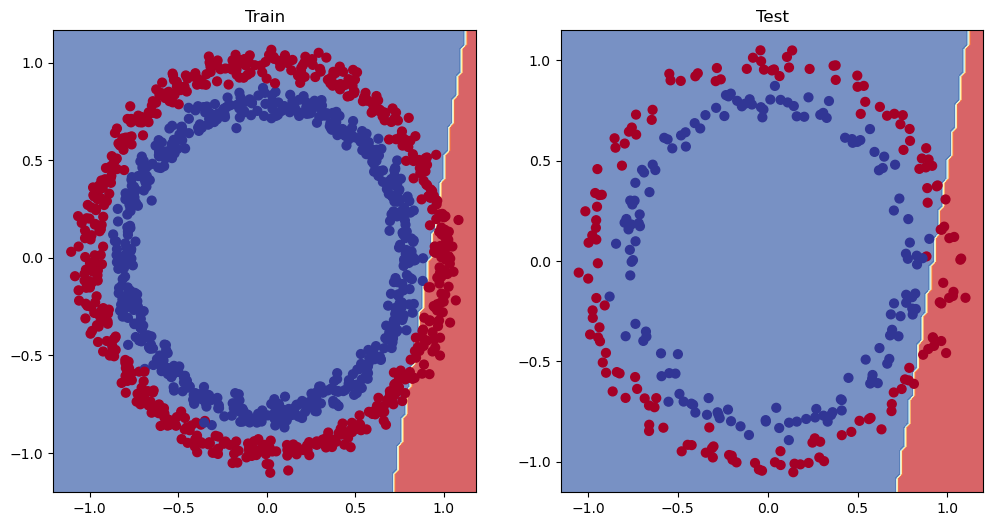

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_C, train_X, train_Y)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_C, test_X, test_Y)

### Model with nonlinearity

In [31]:
class non_lin_circle(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=6)
        self.layer_2 = nn.Linear(in_features=6, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X):
        return self.layer_2(self.relu(self.layer_1(X)))
    
model_new = non_lin_circle().to(device)
model_new

non_lin_circle(
  (layer_1): Linear(in_features=2, out_features=6, bias=True)
  (layer_2): Linear(in_features=6, out_features=1, bias=True)
  (relu): ReLU()
)

In [42]:
epochs = 1500
train_l = []
test_l = []
epoch_count = []
loss_f = nn.BCEWithLogitsLoss()
opti = torch.optim.SGD(model_new.parameters(), lr=.1)

train_X, train_Y = train_X.to(device), train_Y.to(device)
test_X, test_Y = test_X.to(device), test_Y.to(device)

for epoch in range(epochs):

    model_new.train()

    train_logits = model_new(train_X).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logits))

    train_loss = loss_f(train_logits, train_Y)
    train_acc = accuracy_func(train_Y, train_pred)

    opti.zero_grad()
    train_loss.backward()
    opti.step()

    model_new.eval()

    with torch.inference_mode():
        test_logits = model_new(test_X).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_f(test_logits, test_Y)
        test_acc = accuracy_func(test_Y, test_pred)
    
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
        epoch_count.append(epoch)

        # convert to numpy the copy of the tensor that is disconnected 
        # from the computation graph.
        # for scaler, we can also use .item() instead of .detach().numpy()
        train_l.append(train_loss.to("cpu").detach().numpy())
        test_l.append(test_loss.to("cpu").detach().numpy())

Epoch: 0 | Loss: 0.48120, Accuracy: 83.17% | Test Loss: 0.49838, Test Accuracy: 81.33%
Epoch: 50 | Loss: 0.47399, Accuracy: 83.42% | Test Loss: 0.49155, Test Accuracy: 81.67%
Epoch: 100 | Loss: 0.46697, Accuracy: 83.67% | Test Loss: 0.48499, Test Accuracy: 81.67%
Epoch: 150 | Loss: 0.46016, Accuracy: 83.42% | Test Loss: 0.47849, Test Accuracy: 82.33%
Epoch: 200 | Loss: 0.45361, Accuracy: 83.33% | Test Loss: 0.47214, Test Accuracy: 82.00%
Epoch: 250 | Loss: 0.44731, Accuracy: 83.17% | Test Loss: 0.46607, Test Accuracy: 82.33%
Epoch: 300 | Loss: 0.44124, Accuracy: 83.33% | Test Loss: 0.46020, Test Accuracy: 81.67%
Epoch: 350 | Loss: 0.43534, Accuracy: 83.75% | Test Loss: 0.45453, Test Accuracy: 81.33%
Epoch: 400 | Loss: 0.42953, Accuracy: 84.08% | Test Loss: 0.44888, Test Accuracy: 81.33%
Epoch: 450 | Loss: 0.42360, Accuracy: 84.25% | Test Loss: 0.44310, Test Accuracy: 81.67%
Epoch: 500 | Loss: 0.41734, Accuracy: 84.67% | Test Loss: 0.43697, Test Accuracy: 82.67%
Epoch: 550 | Loss: 0.411

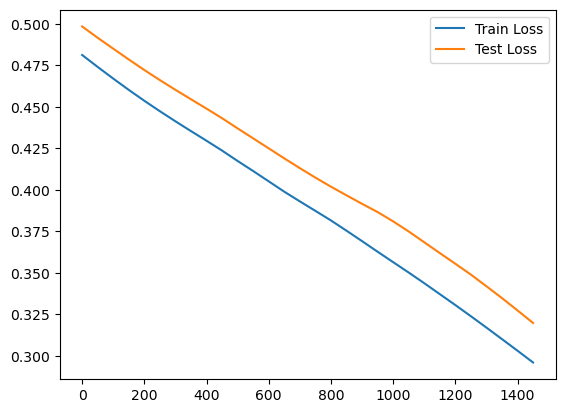

In [43]:
plt.plot(epoch_count, train_l, label='Train Loss')
plt.plot(epoch_count, test_l, label='Test Loss')
plt.legend()
plt.show()

So the training loss is going down consistently

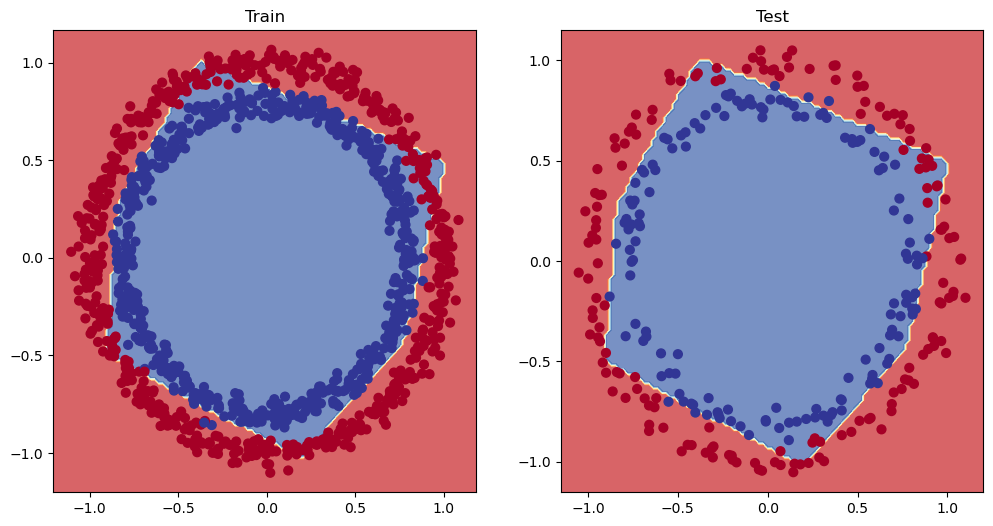

In [44]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_new, train_X, train_Y)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_new, test_X, test_Y)

so the data seems to be getting seperated quite well